In [ ]:
# Execute when running on Google Colab
# !pip install neograd

In [1]:
# Execute when running locally
import sys
sys.path.append('../../tests')
sys.path.append('../..')
import _setup
!pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/pranavsastry/Documents/py/neograd/tests/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import neograd as ng
import numpy as np
from neograd.nn.loss import BCE
from neograd.nn.optim import Adam
from neograd.nn.utils import get_batches
from sklearn.datasets import load_digits

In [16]:
X_train,_ = load_digits(return_X_y=True) # load data

In [17]:
num_train = X_train.shape[0] # number of train examples
num_iter = 200 # number of iterations
batch_size = 200 # batch size in each iteration
print_interval = 50

In [18]:
# normalize inputs
X_train_norm = (X_train - np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)

In [19]:
X_train = ng.tensor(X_train_norm)

In [20]:
class NN(ng.nn.Model):
    def __init__(self):
        self.generator = ng.nn.Sequential(
            ng.nn.Linear(64,50),
            ng.nn.ReLU(),
            ng.nn.Linear(50,25),
            ng.nn.ReLU(),
            ng.nn.Linear(25,64)
        )
        self.discriminator = ng.nn.Sequential(
            ng.nn.Linear(64,50),
            ng.nn.ReLU(),
            ng.nn.Linear(50,25),
            ng.nn.ReLU(),
            ng.nn.Linear(25,1),
            ng.nn.Sigmoid()
        )
    
    def forward(self, inputs):
        noise = ng.tensor(np.random.randn(batch_size, 64))
        generated = self.generator(noise)
        discriminator_fake = self.discriminator(generated)
        discriminator_real = self.discriminator(inputs)
        return discriminator_fake, discriminator_real

In [21]:
model = NN()

model.discriminator.freeze()
optim_generator = Adam(model.get_params(), 5e-3)
model.discriminator.unfreeze()

model.generator.freeze()
optim_discriminator = Adam(model.get_params(), 5e-3)
model.generator.freeze()

loss_fn = BCE()

In [22]:
def train_generator(discriminator_fake, discriminator_real):
    optim_generator.zero_grad()
    optim_discriminator.zero_grad()
    loss_generator = loss_fn(discriminator_fake, ng.tensor(np.ones((discriminator_fake.shape[0],1))))
    loss_generator.backward(retain_graph=True) # retain_graph is True to retain all components that lead to discriminator_fake
    optim_generator.step()
    return loss_generator.data

In [23]:
def train_discriminator(discriminator_fake, discriminator_real):
    optim_generator.zero_grad(all_members=True)
    optim_discriminator.zero_grad(all_members=True)
    loss_real = loss_fn(discriminator_real, ng.tensor(np.ones((discriminator_real.shape[0],1))))
    loss_real.backward(retain_graph=True)
    optim_discriminator.step()
    loss_fake = loss_fn(discriminator_fake, ng.tensor(np.zeros((discriminator_fake.shape[0],1))))
    loss_fake.backward()
    optim_discriminator.step()
    return (loss_real.data+loss_fake.data)/2

In [24]:
def train(discriminator_fake, discriminator_real):
    loss_generator = train_generator(discriminator_fake, discriminator_real)
    loss_discriminator = train_discriminator(discriminator_fake, discriminator_real)
    return loss_generator, loss_discriminator

In [25]:
for i in range(num_iter):
    for inputs_batch in get_batches(X_train, batch_size=batch_size):
        discriminator_fake, discriminator_real = model(inputs_batch)
        loss_generator, loss_discriminator = train(discriminator_fake, discriminator_real)
    if i%print_interval==0:
        print(f'\nIter {i+1}/{num_iter}')
        print(f'Generator loss: {loss_generator}')
        print(f'Discriminator loss: {loss_discriminator}')


Iter 1/200
Generator loss: -1.0000000822403707e-09
Discriminator loss: 10.361632917973205

Iter 51/200
Generator loss: -1.0000000822403707e-09
Discriminator loss: 10.361632917973205

Iter 101/200
Generator loss: 20.72326583694641
Discriminator loss: -1.0000000822403705e-09

Iter 151/200
Generator loss: 20.72326583694641
Discriminator loss: -1.0000000822403705e-09


In [26]:
noise = ng.tensor(np.random.randn(1, 64))
generated = model.generator(noise)

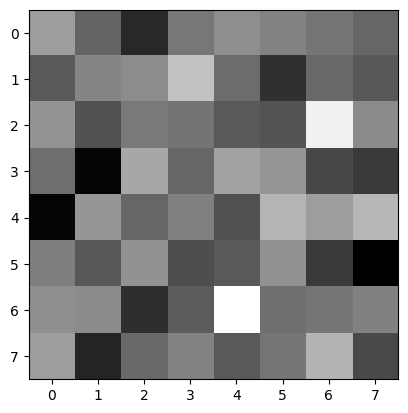

In [27]:
plt.imshow(generated.data.reshape(8,8), cmap='gray')